# Fraud Patterns and Impact in Canada
**Trends, Geography, Demographics and Financial losses**

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import re
from statsmodels.tsa import stattools, seasonal, arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf, plot_predict
import statsmodels.api as sm
from plotly.subplots import make_subplots
import numpy as np
import plotly.express as px
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from scipy.signal import find_peaks
import seaborn as sns
from scipy.stats import chi2_contingency
import unidecode

# DATA PRE-PROCESS
Run before you run in any selected topic belows.

In [4]:
data = pd.read_csv('fraud_data_2021-01-01-to-2024-06-30.csv', )

In [19]:
def data_cleaning_4_raw(data):
    # English Column Extract
    data.columns = [unidecode.unidecode(col) for col in data.columns]

    data = data[[
        "Numero d'identification / Number ID",
        'Date Received / Date recue',
        'Complaint Received Type', 'Country', 'Pays',
        'Province/State',
        'Fraud and Cybercrime Thematic Categories',
        'Solicitation Method', 'Gender','Language of Correspondence',
        "Victim Age Range / Tranche d'age des victimes", 'Complaint Type',
        'Number of Victims / Nombre de victimes',
        'Dollar Loss /pertes financieres']]

    # Rename columns' name in english
    data.rename(columns={
        "Numero d'identification / Number ID":"Number_ID",
        'Date Received / Date recue':"Date_Received",
        'Fraud and Cybercrime Thematic Categories':"Fraud_and_Cybercrime_Thematic_Categories",
        "Victim Age Range / Tranche d'age des victimes":"Victim_Age_Range",
        'Number of Victims / Nombre de victimes':'Number_of_Victims',
        'Dollar Loss /pertes financieres':'Dollar_Loss',
        }, inplace=True)

    # Get Canada's Data only
    data = data.loc[data['Country'].str.contains("Canada", na=False)]
    # Remove Provence = 'California':
    data = data[data['Province/State']!= "California"]
    data.reset_index(inplace=True, drop=True)

    # Columns' type modify
    data['Dollar_Loss'] = data['Dollar_Loss'].map(lambda x: float(re.sub('[$,]','',x)))
    data['Date_Received'] = pd.to_datetime(data['Date_Received'])


    data[data['Province/State'] != 'California']
    return data

clean_data = data_cleaning_4_raw(data)

/var/folders/21/_661td0j1cddth8c88wkc_880000gn/T/ipykernel_99624/348637590.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.rename(columns={


# CYBERCRIME TREND ANALYSIS

## PreProcess Trend Data

In [20]:
clean_data.set_index('Date_Received', inplace=True)

In [21]:
from itertools import count
group_clean_data = clean_data.groupby(pd.Grouper(freq='W')).agg({'Number_ID':'count', 'Dollar_Loss':'sum'})
group_clean_data.rename(columns={'Number_ID':'Cases_Number'}, inplace=True)
group_clean_data.head()

,Cases_Number,Dollar_Loss
Date_Received,,
2021-01-03,93,72269.08
2021-01-10,1472,3464635.85
2021-01-17,1432,3550356.61
2021-01-24,1775,1892402.86
2021-01-31,1816,3405018.22


## Data Visualization


#### Visulization Function

In [22]:
import plotly.graph_objs as go

# Visualization Function
def time_series_vis(title, ps):
    # Create figure
    fig = go.Figure()

    for p in ps:
        fig.add_trace(p)

    # Set title
    fig.update_layout(
        title_text=title,
        title_font=dict(color='black'))

    # Add range slider and update layout
    fig.update_layout(
        height=500,
        font=dict(color='black'),
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label="1m",
                         step="month",
                         stepmode="backward"),
                    dict(count=6,
                         label="6m",
                         step="month",
                         stepmode="backward"),
                    dict(count=1,
                         label="YTD",
                         step="year",
                         stepmode="todate"),
                    dict(count=1,
                         label="1y",
                         step="year",
                         stepmode="backward"),
                    dict(step="all")
                ]),bgcolor='rgba(255, 255, 255, 0)'
            ),
            rangeslider=dict(
                visible=True
            ),
            type="date",
            showgrid=True,
            gridwidth=0.001,
            gridcolor='rgba(255, 255, 255, 0.1)',
            griddash='dash',
            zeroline=False
        ),
        yaxis=dict(
            showgrid=True,
            gridwidth=0.001,
            gridcolor='rgba(255, 255, 255, 0.1)',
            griddash='dash',
            zeroline=False
        )
    )

    fig.show()


#### Cases Numbers Observation (Weekly)

Trend Observation
Detect fraudulent activities through data visualization to identify trending patterns in relation to time factors. We apply an Additive Model to extract time series data to trend, seasonal and residual. What we can tell from the plot below is that the trend decreases annually..


Additive Method:$$Oberserved = Trend + Seasonal + Resid$$

In [23]:
# Data Extraction Visualization Parameters Define

extracted_result = seasonal.seasonal_decompose(
    group_clean_data.Cases_Number,
    # Considering Change Range not following the Trend
    model='add',
    # For weekly data
    period=12,
    # Avoid NaN Data
    extrapolate_trend=True
    )

In [25]:
# Visualize the data
extract_pic = [
    go.Scatter(x=group_clean_data.index, y=extracted_result.observed, name='data'),
    go.Scatter(x=group_clean_data.index, y=extracted_result.trend, name='trend'),
    go.Scatter(x=group_clean_data.index, y=extracted_result.seasonal, name='seasonal'),
    go.Scatter(x=group_clean_data.index, y=extracted_result.resid, name='resid')
]

time_series_vis('Observation of Fraud Cases Trend',extract_pic)



## Seasonal Analysis



#### Trend Removing

To effectively conduct seasonal analysis, it is essential to eliminate the trend component from the observed data. There are two primary methods for achieving this:
- Additive Model: This approach involves calculating the observed data minus the trend component. It is straightforward and quick; while it may not completely eliminate all trends, it provides a clearer signal from the observed data.


In [26]:
# Remove the trend component from observed data
group_clean_data['no_trend'] =(extracted_result.observed - extracted_result.trend)

no_trend = [
    go.Scatter(x=group_clean_data.index, y=group_clean_data.no_trend, name='no_trend_data'),
]
time_series_vis('Observation of Trend Removed Cases Data', no_trend)

#### ACF/PACF Testing

Periodicity Impact Analysis
To determine the routine cycle of fraud data trends, we utilize the ACF and PACF methods to calculate the periodicity.

- ACF: This method assesses how today's value correlates with values from several previous time steps.

- PACF: This method evaluates how today's value is influenced directly by a specific past value, while disregarding the values in between.

By analyzing the results from the ACF and PACF data, we can effectively identify the cycle period that has the most significant impact on the data points at any given time.


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



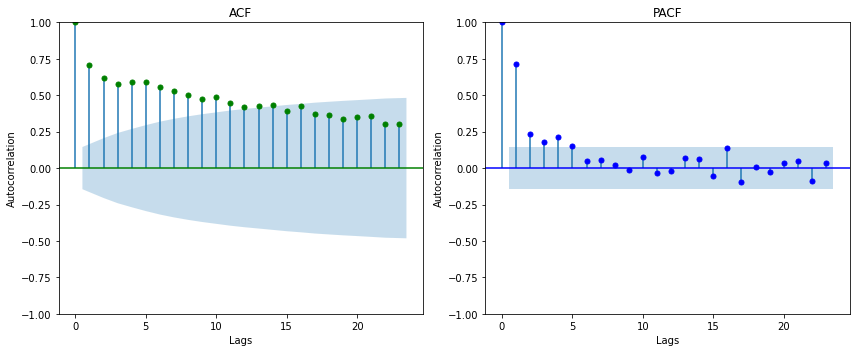

In [27]:
# Grid Vis
fig = make_subplots(rows=2, cols=2, )
fig, axs = plt.subplots(1, 2, figsize=(12, 5))


for ax in axs:
    ax.set_xlabel('Lags', color='black')
    ax.set_ylabel('Autocorrelation', color='black')
    ax.tick_params(axis='x', colors='black')
    ax.tick_params(axis='y', colors='black')
    ax.title.set_color('black')

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_color('black')


# ACF/ PACF Drawing
plot_acf(group_clean_data['Cases_Number'], ax=axs[0], title='ACF', color='green')
plot_pacf(group_clean_data['Cases_Number'], ax=axs[1], title='PACF', color='blue')

plt.tight_layout()
plt.show()


#### Intensity Frequency Analysis
After thoroughly analyzing the regular pattern period, we can utilize the Exponential Moving Average (EMA) to assess and confirm the seasonal intensity of data that does not exhibit a trend. This method allows us to pinpoint specific periods when fraud cases are on the rise and when they are decreasing.

We prefer the Exponential Moving Average (EMA) over the Simple Moving Average (MA) because it minimizes the influence of historical data on future predictions, as illustrated in the Autocorrelation Function (ACF) plot. These factors are essential to our analysis.


In [28]:
# Decided by previous ACF
WINDOW_SIZE = 12

model = ExponentialSmoothing(group_clean_data.no_trend, seasonal='add', seasonal_periods=WINDOW_SIZE)
ema_results = model.fit(optimized=True)

# find peaks
peaks, properties = find_peaks(ema_results.fittedvalues.values)
# print("Peaks Value:", ema_results.fittedvalues.iloc[peaks])

no_trend_ema = [
    go.Scatter(x=ema_results.fittedvalues.index, y=ema_results.fittedvalues, name='Cases_Number'),
    go.Scatter(x=ema_results.fittedvalues.iloc[peaks].index,
                         y=ema_results.fittedvalues.iloc[peaks].values,
                         mode='markers',
                         marker=dict(symbol="x", size=10, color='red'),
                         name='peaks')
]
time_series_vis(f'Trend Removed Cases Data EMA({WINDOW_SIZE})', no_trend_ema)

#### Fourier Transform
To begin with, we aim to comprehend the frequency of patterns. While we are aware of the routine period, the intensity frequency remains unclear. To uncover this information, we will utilize the Fourier Transform.


In [29]:
from scipy.fft import fft, fftfreq, ifft

y = ema_results.fittedvalues.values
n = len(y)
T = 1

yf = fft(y)
xf = fftfreq(n, T)[:n//2]


amplitude = 2.0/n * np.abs(yf[0:n//2])

peaks, _ = find_peaks(amplitude, height=20)
peak_values = amplitude[peaks]

frequencies = xf[peaks]
inverse_frequencies = 1 / frequencies

for freq, peak, inv_freq in zip(xf[peaks], peak_values, inverse_frequencies):
    print(f"Frequency: {freq:.2f} Hz, Peak: {peak:.2f}, inverse_frequencies: {inv_freq:.2f} weeks")


fig = go.Figure()
fig.add_trace(go.Scatter(x=xf, y=amplitude, mode='lines', name='Magnitude'))

fig.update_layout(
        title='Fourier Transform Spectrum',
        xaxis_title='Frequency (Hz)',
      yaxis_title='Magnitude',
      template='plotly_white',
        height=500,
        font=dict(color='Black'),
        xaxis=dict(
            showgrid=True,
            gridwidth=0.001,
            gridcolor='rgba(255, 255, 255, 0.1)',
            griddash='dash',
            zeroline=False
        ),
        yaxis=dict(
            showgrid=True,
            gridwidth=0.001,
            gridcolor='rgba(255, 255, 255, 0.1)',
            griddash='dash',
            zeroline=False
        )
    )
fig.show()

Frequency: 0.08 Hz, Peak: 47.03, inverse_frequencies: 12.20 weeks
Frequency: 0.16 Hz, Peak: 33.75, inverse_frequencies: 6.10 weeks
Frequency: 0.25 Hz, Peak: 52.98, inverse_frequencies: 3.98 weeks
Frequency: 0.33 Hz, Peak: 31.37, inverse_frequencies: 3.00 weeks
Frequency: 0.42 Hz, Peak: 37.43, inverse_frequencies: 2.41 weeks


#### Crrelation Analysis (Week of Month & Month)

We performed a ***Chi-square test*** to assess whether the frequency of fraud cases varied significantly across different weeks of the month and across various months. The objective was to identify any discernible patterns in the timing of fraud incidents, which could help reveal if particular weeks within a month are more susceptible to fraud, depending on the month.

In [30]:
clean_data['Month'] = clean_data.index.month
def get_week_of_month(dt):
    first_day = dt.replace(day=1)
    dom = dt.day
    if (dom + first_day.weekday() - 1) // 7 + 1 < 6:

      return (dom + first_day.weekday() - 1) // 7 + 1

clean_data['WeekOfMonth'] = clean_data.index.map(get_week_of_month)

Chi-squared: 10166.38
p-value: 0.0
Degrees of Freedom: 44
Results are significant: There is a significant correlation between the occurrence of fraud cases and the month and week of the month.


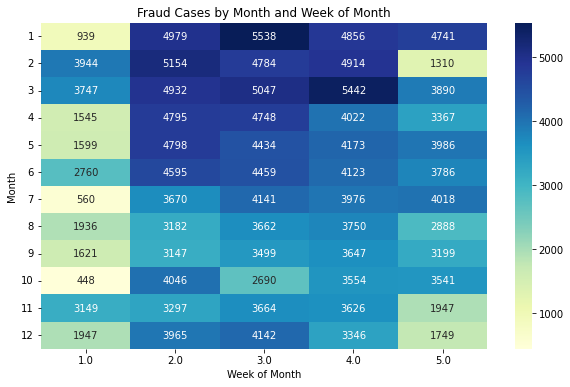

In [31]:
contingency_table = pd.crosstab(clean_data['Month'], clean_data['WeekOfMonth'])

chi2, p, dof, ex = chi2_contingency(contingency_table.values)

print(f"Chi-squared: {chi2:.2f}")
print(f"p-value: {p}")
print(f"Degrees of Freedom: {dof}")

alpha = 0.05
if p < alpha:
    print("Results are significant: There is a significant correlation between the occurrence of fraud cases and the month and week of the month.")
else:
    print("Results are not significant: We cannot reject the hypothesis that the occurrence of fraud cases is not related to the month and week of the month.")
plt.figure(figsize=(10, 6))
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlGnBu', cbar=True)
plt.title('Fraud Cases by Month and Week of Month')
plt.xlabel('Week of Month')
plt.ylabel('Month')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.show()


The chi-square test conducted on the relationship between "month" and "week of the month" indicates a significant correlation, with a p-value less than 0.05. This suggests that certain months are associated with a higher frequency of fraud cases occurring during specific weeks.



## Conclusion

Based on the analyses conducted, the following conclusions are drawn:

There is a notable downward trend in the number of fraud cases over the analyzed period.

Periodic patterns of 12 weeks and 4 weeks are observed, with future predictions suggesting continued peaks during specific periods, particularly within the 4-week, 6-week, and 12-week cycles, where risks are expected to increase significantly.

The Chi-square test results affirm a substantial relationship between the month and week of the month concerning fraud cases, offering valuable insights for risk forecasting and resource allocation.

These insights provide substantial data support for organizations, aiding them in making well-informed decisions regarding resource allocation and risk management.
